# Spatial Feature Engineering (train.csv, test.csv)

# Update

## Previous Steps Saved in Other Notebooks

1 Data Loading + Missing Value

    1.1 Training Set
    1.2 Testing Set
    1.3 Macro Set
    1.4 Merging (for visualization)
    
2 Data Cleaning + First Pass Visualization

    2.1 Training set first 13 cols cleaning (from Shu's "Data Understanding & Data Preparation" section)
    2.2 Price distribution anamaly deep dive
    2.3 First pass categorical plots
    2.4 Full corr matrix plot (merge train and macro)
    
3 Feature Engineering and Selection

    3.1 Macro cols selection based on VIF
    3.2 Train set feature generation by Shu
    3.3 Merge in sub_area long lat info from shape files
    
    --------- Generate Output ---------
    train_lonlat_id_CS_0521.csv
    test_lonlat_id_CS_0521.csv
    -----------------------------------
    
    <====== This notebook starts from here








## Cleaned Data Loading

In [1]:
import numpy as np 
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import math
import xgboost as xgb
from sklearn import model_selection, preprocessing
from pandas.io.json import build_table_schema
import visualization as vis
from pandas.plotting import scatter_matrix
%matplotlib inline

color = sns.color_palette()

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)  # this is needed since the combined df has ~400 cols

/Users/chao/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [118]:
df_train = pd.read_csv('./Data/train_lonlat_id_CS_0521.csv',
                       header='infer',
                       index_col='id',
                       parse_dates=['timestamp']) # a subfolder named "Data" stores the raw csv files from Kaggle
df_test  = pd.read_csv('./Data/test_lonlat_id_CS_0521.csv',
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp'])
df_macro = pd.read_csv('./Data/macro.csv',
                       header='infer',
                       parse_dates=['timestamp'])

test_id  = df_test.index
train_id = df_train.index

In [3]:
print df_train.shape
print df_test.shape # test does not have 'price_doc','log_price_doc' and 'unit_price'

(30471, 301)
(7662, 298)


In [4]:
print 'new train.csv columns created during the data cleaning stage'
print df_train.columns[291:]
print 'new test.csv columns created during the data cleaning stage'
print df_test.columns[290:]

new train.csv columns created during the data cleaning stage
Index([u'sq_metr', u'unit_price', u'log_price_doc', u'year', u'month',
       u'product_type_le', u'sub_area_le', u'lon', u'lat', u'OKRUGS'],
      dtype='object')
new test.csv columns created during the data cleaning stage
Index([u'sq_metr', u'year', u'month', u'product_type_le', u'sub_area_le',
       u'lon', u'lat', u'OKRUGS'],
      dtype='object')


### High Level Column Content Digestion Notes

'**timestamp**'(0): this is what makes this competition special -- it has a time dimension. **The training data set and test data set do NOT overlap in time**. The macro economy csv files covers the whole time range of train + test.

'**full_sq**' to '**state**'(1-9): these are detailed description of each listing unit. 

'**product_type**'(10): investment or owner occupied

'**sub_area**' to '**build_count_after_1995**'(11-82): neighborhood info. **For all the listings in the same sub_area, all info in col 12-83 are the SAME. When comparing listings in the same sub_area, all these columns are useless.** If we take the intuitive approach to predict price only using the training info from the same sub_area, these columns would be useless. Input and target distribution for each sub_area need to be looked at. 

'**ID_metro**' to '**ecology**'(83-151): These are listing specific info. Most of them are distances (in km) to the nearest POI's. A few of them have **ID**'s, which can be used to further pin down where the listing is within a sub_area, especially with a map. The distance items could be potentially be grouped into 'good' and 'bad' POI's, and do a sum of 1/d to get "number of good/bad stuff per 1 km" feature. A few things like ecology are categorical, and should be important for predicting housing price.

**Everything after ecology till the last column**(152-289): these are POI counts for specific radius. It is important to think about the spatial sensitivity decay when we increase the radius. To reduce multicollinearity, I think it's better to do a few subtraction to get counts in a donut area, so columns are more independent from each other.

'**price_doc**'(290): This is the price we try to predict.

**after 290/291 there are new columns created during data cleaning stage**

In [19]:
# df_train.dtypes.tolist

### 1.4 Merge train , test datasets with macro on 'timestamp' column 
**This does NOT mean we will start by pushing the entire input data into a black box. This merge is for certain EDA visualization. We will need to understand the data piece by piece.**

In [5]:
# df_macro.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in df_macro.columns ]

# df_train_macro = df_train.merge(df_macro,on='timestamp',how = 'left')
# df_test_macro  = df_test.merge(df_macro,on='timestamp',how = 'left')

# print(df_train_macro.shape)
# print(df_test_macro.shape)

### 2.2 'price_doc' distribution deep dive

In [6]:
#cols = df_train.columns

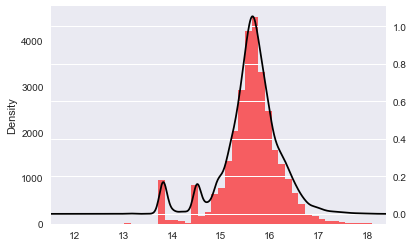

In [8]:
vis.hist_density_plot(df_train, x='price_doc', logx=True)

# Place Holder
After the log transform, the price distribution is much more symmetric.
Notice the interesting 2 anomalies on the left side of the main peak. They are found to be associated to **product_type == investment**. We will dive into this more.

### 2.4 Full Correlation Matrix Plot

In [31]:
# df_train_macro_corr = df_train_macro.corr() 
# mask = np.zeros_like(df_train_macro_corr)
# mask[np.triu_indices_from(mask)] = True
# f, ax = plt.subplots(figsize=(50, 50))
# with  sns.axes_style("white"):
#     ax = sns.heatmap(df_train_macro_corr,
# #             annot=True,
#             mask = mask, 
#             square = True
#            )
# plt.show()

# 3 Feature Engineering and Selection

## 3.1 Macro feature selection based on VIF study on Kaggle forum

In [32]:
# We need to do a similar study

# These are the kept cols after a VIF study in R: https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity
# Someone posted a Python version: https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
# Which might be sped up this way (quickly drop once VIF is higher than a threshold): 
# https://www.kaggle.com/jbucker/sklearn-multicollinearity-class-speedup
macro_cols = ['timestamp','eurub','usdrub','micex_cbi_tr',
              'brent','micex','micex_rgbi_tr',
              'rts','oil_urals','cpi','ppi','quart',
              'rent_price_1room_bus','rent_price_4+room_bus',
              'net_capital_export','mortgage_rate','balance_trade',
              'rent_price_3room_eco','deposits_value','gdp_quart_growth',
              'balance_trade_growth','rent_price_2room_bus','mortage_growth',
              'income_per_cap','rent_price_2room_eco','fixed_basket',
              'rent_price_1room_eco','mortgage_value','rent_price_3room_bus',
              'deposits_rate',"balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
              "micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
              "income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build","timestamp"]
macro_cols = list(set(macro_cols))
len(macro_cols)
# df_macro = df_macro.loc[:,macro_cols]

34

## 3.3 Normalization Features (These are not included in the output CSV)

In [33]:
# ylog_train_all = np.log1p(df_train['price_doc'].values)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train) # use it to split train test after merge
df_all = pd.concat([df_train, df_test])

# # Merge with econ data

# df_macro.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in df_macro.columns ]
# df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
# print(df_all.shape)

# df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])

In [34]:
# df_all.iloc[num_train:,:] # this is test.csv

### Create new features

timestamp transformation

**the transation volumnm features have been proven useful
the question is: they are time domain info, how are these correlated to the macro econamy info? How to divide up spatial and temporal information if that's the way we structure the code?**

In [35]:
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

Calculate business density

##### Count density

In [92]:
# for i in df_all.columns:
#     for j in df_all.columns:
#         if ('count_500' in i ) and ('count_5000' not in i) \
#            and ('count_1000' in j) and \
#             (i.replace('count_500','') == j.replace('count_1000','')):
#             col_name = i.replace('count_500','')+'_05km_1km_count_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (1**2-0.5**2))
#         elif ('count_1000' in i) and ('count_1500' in j) and \
#         (i.replace('count_1000','') == j.replace('count_1500','')):
#             col_name = i.replace('count_1000','')+'_1km_1_5km_count_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (1.5**2-1**2))
#         elif ('count_1500' in i) and ('count_2000' in j) and \
#         (i.replace('count_1500','') == j.replace('count_2000','')):
#             col_name = i.replace('count_1500','')+'_1_5km_2km_count_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (2**2-1.5**2))
#         elif ('count_2000' in i) and ('count_3000' in j) and \
#         (i.replace('count_2000','') == j.replace('count_3000','')):
#             col_name = i.replace('count_2000','')+'_2km_3km_count_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (3**2-2**2))
#         elif ('count_3000' in i) and ('count_5000' in j) and \
#         (i.replace('count_3000','') == j.replace('count_5000','')):
#             col_name = i.replace('count_3000','')+'_3km_5km_count_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (5**2-3**2))


In [93]:
# for i in df_all.columns:
#     if ('count_500' in i ) or\
#     ('count_1000' in i ) or\
#     ('count_1500' in i ) or\
#     ('count_2000' in i ) or\
#     ('count_3000' in i ) or\
#     ('count_5000' in i ):
#         df_all.drop([i],axis=1,inplace=True)
# #         print(i)

#### Sqm density

In [94]:
# for i in df_all.columns:
#     for j in df_all.columns:
#         if ('sqm_500' in i ) and ('sqm_5000' not in i) \
#            and ('sqm_1000' in j) and \
#             (i.replace('sqm_500','') == j.replace('sqm_1000','')):
#             col_name = i.replace('sqm_500','')+'_05km_1km_sqm_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (1000**2-500**2))
#         elif ('sqm_1000' in i) and ('sqm_1500' in j) and \
#         (i.replace('sqm_1000','') == j.replace('sqm_1500','')):
#             col_name = i.replace('sqm_1000','')+'_1km_1_5km_sqm_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (1500**2-1000**2))
#         elif ('sqm_1500' in i) and ('sqm_2000' in j) and \
#         (i.replace('sqm_1500','') == j.replace('sqm_2000','')):
#             col_name = i.replace('sqm_1500','')+'_1_5km_2km_sqm_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (2000**2-1500**2))
#         elif ('sqm_2000' in i) and ('sqm_3000' in j) and \
#         (i.replace('sqm_2000','') == j.replace('sqm_3000','')):
#             col_name = i.replace('sqm_2000','')+'_2km_3km_sqm_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (3000**2-2000**2))
#         elif ('sqm_3000' in i) and ('sqm_5000' in j) and \
#         (i.replace('sqm_3000','') == j.replace('sqm_5000','')):
#             col_name = i.replace('sqm_3000','')+'_3km_5km_sqm_density'
#             df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (5000**2-3000**2))

In [95]:
# for i in df_all.columns:
#     if ('sqm_500' in i ) or\
#     ('sqm_1000' in i ) or\
#     ('sqm_1500' in i ) or\
#     ('sqm_2000' in i ) or\
#     ('sqm_3000' in i ) or\
#     ('sqm_5000' in i ):
#         df_all.drop([i],axis=1,inplace=True)
# #         print(i)

#### Population data transformation

In [36]:
# # Aging population
# df_all['elder_percent'] = df_all['ekder_all']/df_all['full_all']
# df_all.loc[df_all['elder_percent']>1,'elder_percent']=np.mean(df_all.loc[df_all['elder_percent']<=1,'elder_percent'])
# sns.violinplot(data=df_all,y='elder_percent')
# plt.show()

In [37]:
# # Working population percentage
# df_all['work_pop_percent'] = df_all['work_all']/df_all['full_all']
# df_all.loc[df_all['work_pop_percent']>1,'work_pop_percent']=np.mean(df_all.loc[df_all['work_pop_percent']<=1,'work_pop_percent'])
# sns.violinplot(data=df_all,y='work_pop_percent')
# plt.show()

In [38]:
# #Working male / working all
# df_all['work_male_percent'] = df_all['work_male']/df_all['work_all']
# df_all.loc[df_all['work_male_percent']>1,'work_male_percent']=np.mean(df_all.loc[df_all['work_male_percent']<=1,'work_male_percent'])
# sns.violinplot(data=df_all,y='work_male_percent')
# plt.show()

In [39]:
# for i in df_all.columns:
#     if ('male' in i) and (i != 'work_male_percent'):
#         df_all.drop([i],axis=1, inplace=True)
#         print(i)

## population density

In [40]:
# region population density
df_all['popden']=df_all['raion_popul']/df_all['area_m']
# df_all['healthcare_center_1k_capita']=df_all['healthcare_centers_raion']/df_all['raion_popul']*1000
# df_all['shopping_center_1k_capita']=df_all['shopping_centers_raion']/df_all['raion_popul']*1000
# df_all['office_1k_capita']=df_all['office_raion']/df_all['raion_popul']*1000
# df_all['big_market_1k_capita']=df_all['big_market_raion']/df_all['raion_popul']*1000


## Housing info transformation. notice in house_age there are negative numbers. on kaggle forum the sberbank lady said those are pre-purchases (transaction date < build year)

In [41]:
# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)
df_all['life_full_sq_ratio'] = df_all['life_sq']/df_all['full_sq']
df_all['avg_room_sq'] = (df_all['life_sq']-df_all['kitch_sq'])/df_all['num_room']
df_all['house_age'] = df_all['year'] - df_all['build_year']


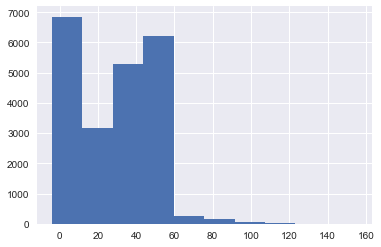

In [66]:
df_all['house_age'].hist()

## changing the nearest...ID... to categorical columns

In [82]:
# change ID variable to categorical variables
df_all[['ID_big_road1','ID_big_road2',
        'ID_bus_terminal','ID_metro',
       'ID_railroad_station_avto',
       'ID_railroad_terminal']]=df_all[['ID_big_road1','ID_big_road2',
                                        'ID_bus_terminal','ID_metro',
                                       'ID_railroad_station_avto',
                                       'ID_railroad_terminal']].astype(object)

In [98]:
# change ID variable to categorical variables
df_train[['ID_big_road1','ID_big_road2',
        'ID_bus_terminal','ID_metro',
       'ID_railroad_station_avto',
       'ID_railroad_terminal']]=df_train[['ID_big_road1','ID_big_road2',
                                        'ID_bus_terminal','ID_metro',
                                       'ID_railroad_station_avto',
                                       'ID_railroad_terminal']].astype(object)

In [83]:
df_all.loc[:,df_all.dtypes=='object']

,ID_big_road1,ID_big_road2,ID_bus_terminal,ID_metro,ID_railroad_station_avto,ID_railroad_terminal,OKRUGS,big_market_raion,big_road1_1line,culture_objects_top_25,detention_facility_raion,ecology,incineration_raion,nuclear_reactor_raion,oil_chemistry_raion,product_type,radiation_raion,railroad_1line,railroad_terminal_raion,sub_area,thermal_power_plant_raion,water_1line
id,,,,,,,,,,,,,,,,,,,,,,
1,1,5,1,1,1,101,North-Eastern,no,no,no,no,good,no,no,no,Investment,no,no,no,Bibirevo,no,no
2,2,4,2,2,2,32,Southern,no,no,yes,no,excellent,no,no,no,Investment,no,no,no,Nagatinskij Zaton,no,no
3,3,4,3,3,3,5,South-Eastern,no,no,no,no,poor,no,no,no,Investment,yes,no,no,Tekstil'shhiki,no,no
4,1,17,1,4,4,83,North-Western,no,no,no,no,good,no,no,no,Investment,no,no,no,Mitino,no,no
5,4,10,4,5,113,113,Central,no,no,no,no,excellent,no,no,no,Investment,yes,yes,yes,Basmannoe,no,no
6,4,3,4,6,6,5,South-Eastern,no,no,no,no,poor,no,no,no,Investment,yes,no,no,Nizhegorodskoe,yes,no
7,4,20,4,7,7,97,Eastern,no,no,no,yes,poor,no,no,no,Investment,no,no,no,Sokol'niki,no,no
8,1,36,1,8,1,101,North-Eastern,no,no,no,no,good,no,no,no,Investment,no,no,no,Bibirevo,no,no
9,5,14,5,9,9,121,Northern,no,no,no,no,poor,no,no,no,Investment,no,no,no,Koptevo,no,no


## find average housing price represented by some key categorical features: sub_area, okrugs, ID_metro (nearest metro station). notice the difference in 'resolution' of these features.

In [112]:
df_price = df_train.loc[:,['sub_area','OKRUGS','ID_metro','price_doc','unit_price','log_price_doc']]
# df_price.shape
train_sub_area_median = df_price.groupby(['sub_area']).agg(np.median)
train_OKRUGS_median = df_price.groupby(['OKRUGS']).agg(np.median)
train_ID_metro_median = df_price.groupby(['ID_metro']).agg(np.median)

In [113]:
train_sub_area_median.columns = train_sub_area_median.columns + '_sub_area'
train_OKRUGS_median.columns   = train_OKRUGS_median.columns + '_OKRUGS'
train_ID_metro_median.columns = train_ID_metro_median.columns + '_ID_metro'

train_sub_area_median['sub_area'] = train_sub_area_median.index
train_OKRUGS_median['OKRUGS']     = train_OKRUGS_median.index
train_ID_metro_median['ID_metro'] = train_ID_metro_median.index

In [114]:
df_all = df_all.merge(train_sub_area_median,on='sub_area',how = 'left')
df_all = df_all.merge(train_OKRUGS_median,on='OKRUGS',how = 'left')
df_all = df_all.merge(train_ID_metro_median,on='ID_metro',how = 'left')

In [116]:
df_all.head(10)

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,16_29_female,16_29_male,7_14_all,7_14_female,7_14_male,ID_big_road1,ID_big_road2,ID_bus_terminal,ID_metro,ID_railroad_station_avto,ID_railroad_station_walk,ID_railroad_terminal,OKRUGS,additional_education_km,additional_education_raion,area_m,basketball_km,big_church_count_1000,big_church_count_1500,big_church_count_2000,big_church_count_3000,big_church_count_500,big_church_count_5000,big_church_km,big_market_km,big_market_raion,big_road1_1line,big_road1_km,big_road2_km,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,build_count_before_1920,build_count_block,build_count_brick,build_count_foam,build_count_frame,build_count_mix,build_count_monolith,build_count_panel,build_count_slag,build_count_wood,build_year,bulvar_ring_km,bus_terminal_avto_km,cafe_avg_price_1000,cafe_avg_price_1500,cafe_avg_price_2000,cafe_avg_price_3000,cafe_avg_price_500,cafe_avg_price_5000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_500,cafe_count_1000_price_high,cafe_count_1500,cafe_count_1500_na_price,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_500,cafe_count_1500_price_high,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_500,cafe_count_2000_price_high,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_500,cafe_count_3000_price_high,cafe_count_500,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_500,cafe_count_5000_price_high,cafe_count_500_na_price,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_500,cafe_count_500_price_high,cafe_sum_1000_max_price_avg,cafe_sum_1000_min_price_avg,cafe_sum_1500_max_price_avg,cafe_sum_1500_min_price_avg,cafe_sum_2000_max_price_avg,cafe_sum_2000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_sum_3000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_sum_5000_min_price_avg,cafe_sum_500_max_price_avg,cafe_sum_500_min_price_avg,catering_km,cemetery_km,children_preschool,children_school,church_count_1000,church_count_1500,church_count_2000,church_count_3000,church_count_500,church_count_5000,church_synagogue_km,culture_objects_top_25,culture_objects_top_25_raion,detention_facility_km,detention_facility_raion,ecology,ekder_all,ekder_female,ekder_male,exhibition_km,female_f,fitness_km,floor,full_all,full_sq,green_part_1000,green_part_1500,green_part_2000,green_part_3000,green_part_500,green_part_5000,green_zone_km,green_zone_part,healthcare_centers_raion,hospice_morgue_km,hospital_beds_raion,ice_rink_km,incineration_km,incineration_raion,indust_part,industrial_km,kindergarten_km,kitch_sq,kremlin_km,lat,leisure_count_1000,leisure_count_1500,leisure_count_2000,leisure_count_3000,leisure_count_500,leisure_count_5000,life_sq,log_price_doc,lon,male_f,market_count_1000,market_count_1500,market_count_2000,market_count_3000,market_count_500,market_count_5000,market_shop_km,material,max_floor,metro_km_avto,metro_km_walk,metro_min_avto,metro_min_walk,mkad_km,month,mosque_count_1000,mosque_count_1500,mosque_count_2000,mosque_count_3000,mosque_count_500,mosque_count_5000,mosque_km,museum_km,nuclear_reactor_km,nuclear_reactor_raion,num_room,office_count_1000,office_count_1500,office_count_2000,office_count_3000,office_count_500,office_count_5000,office_km,office_raion,office_sqm_1000,office_sqm_1500,office_sqm_2000,office_sqm_3000,office_sqm_500,office_sqm_5000,oi

In [102]:
# # Remove timestamp column (may overfit the model in train)
# df_all.drop(['timestamp'], axis=1, inplace=True)

In [132]:
df_all['id'] = train_id.tolist() + test_id.tolist()

df_all.iloc[:num_train,:].to_csv('train_lonlat_id_CS_0521_feature.csv',index=False)
df_all.iloc[num_train:,:].to_csv('test_lonlat_id_CS_0521_feature.csv',index=False)